In [1]:
# Import TensorFlow and its Keras API components
# Models - provides classes to build, manage, and train neural network models
# Layers - contains all the building blocks of a neural network.
import tensorflow as tf
from tensorflow.keras import models, layers

# Import Matplotlib for visualizing training metrics, images, or model performance
import matplotlib.pyplot as plt

In [2]:
# Number of images processed in one forward/backward pass.
# Higher batch size = faster training but requires more memory.
BATCH_SIZE = 32

# Target height/width (in pixels) to which all images will be resized.
# Ensures uniform input size for the neural network.
IMAGE_SIZE = 256

# Number of color channels in the image.
# 3 channels = RGB images (standard color pictures).
CHANNELS = 3

# Number of complete passes through the entire dataset during training.
# More epochs = better learning, but risk of overfitting if too high.
EPOCHS = 50

In [3]:
# Load images from the 'PlantVillage' directory and create a TensorFlow dataset.
# This utility automatically labels images based on their subfolder names.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",      # Path to the root dataset folder
    shuffle=True,        # Randomize the order of images for better training
    image_size=IMAGE_SIZE,  # Resize all images to (IMAGE_SIZE x IMAGE_SIZE)
    batch_size=BATCH_SIZE   # Number of images per batch during training
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1]


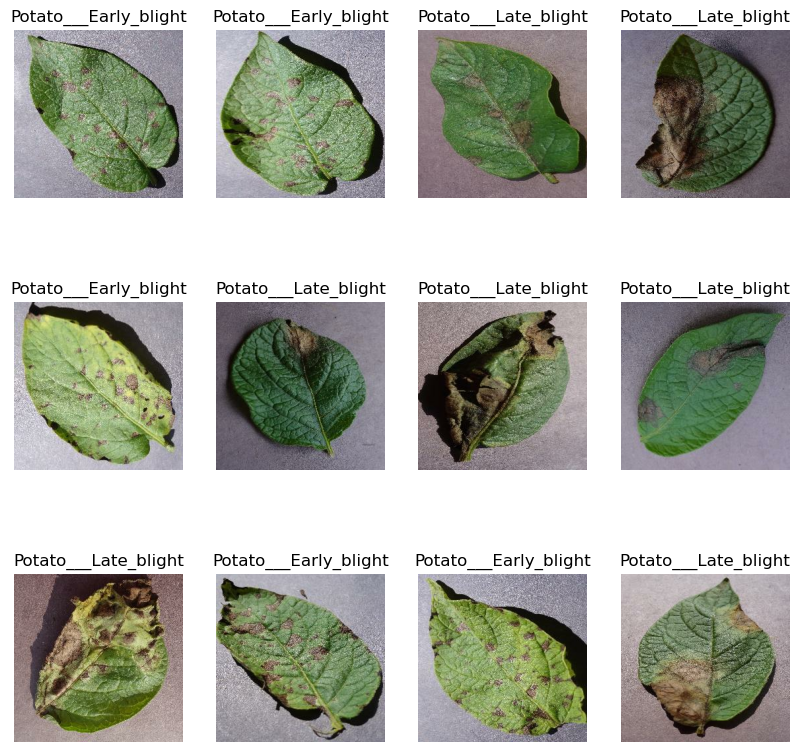

In [5]:
# Create a plotting canvas of size 10x10 for displaying sample images.
plt.figure(figsize=(10, 10))

# Take one batch from the dataset to visualize images and their labels.
for image_batch, labels_batch in dataset.take(1):
    
    # Display the shape of the image batch.
    # Format: (batch_size, height, width, channels)
    print(image_batch.shape)

    # Display the corresponding numeric labels for the batch.
    print(labels_batch.numpy())

    # Plot the first 12 images from the batch.
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)

        # Show the image as uint8 (0–255) to display correctly.
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # Set the title using the class name (mapped from label).
        plt.title(class_names[labels_batch[i]])

        # Hide axis ticks for cleaner visualization.
        plt.axis("off")